In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import json
import nltk
import wordcloud
import spacy

In [5]:
df = pd.read_json("../data/eightportions/recipes_raw_nosource_ar.json", 'index')
df.head()

,title,ingredients,instructions,picture_link
rmK12Uau.ntP510KeImX506H6Mr6jTu,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ...",55lznCYBbs2mT8BTx6BTkLhynGHzM.S
5ZpZE8hSVdPk2ZXo1mZTyoPWJRSCPSm,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ...",QyrvGdGNMBA2lDdciY0FjKu.77MM0Oe
clyYQv.CplpwJtjNaFGhx0VilNYqRxu,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....,LVW1DI0vtlCrpAhNSEQysE9i/7rJG56
BmqFAmCrDHiKNwX.IQzb0U/v0mLlxFu,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....,0SO5kdWOV94j6EfAVwMMYRM3yNN8eRi
N.jCksRjB4MFwbgPFQU8Kg.yF.XCtOi,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...,YCnbhplMgiraW4rUXcybgSEZinSgljm


In [6]:
print(f"Number of recipes before dropna: {len(df)}")
df.dropna(inplace=True, subset=["instructions","ingredients"])
print(f"Number of recipes after dropna: {len(df)}")

Number of recipes before dropna: 39522
Number of recipes after dropna: 39522


## Ingredients

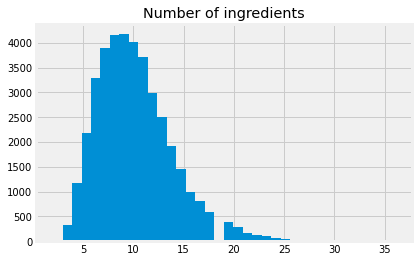

Median number of ingredients: 10.0
Std. deviation of number of ingredients: 3.95


In [7]:
def count_ingredients(ingredients):
    if isinstance(ingredients, list):
        return len(ingredients)
    else:
        return 0

df['n_ingredients'] = df.ingredients.apply(count_ingredients)

#plot distribution
plt.title("Number of ingredients")
plt.hist(df.n_ingredients.tolist(), bins=max(df.n_ingredients.tolist()))
plt.show()

print(f"Median number of ingredients: {df.n_ingredients.median()}")
print(f"Std. deviation of number of ingredients: {df.n_ingredients.std():.2f}")

The median number of ingredients is 9, which seems plausible. There are some recipes that require a lot of ingredients, i.e. the distribution is long tailed. However, the majority has 1-20 ingredients. There are some ingredients that require no ingredients (i.e. those are nan values or empty lists)

In [11]:
for i in range(0):
    recipe = df[df.n_ingredients == 0].iloc[i]
    print("{}: {}".format(recipe.title, len(recipe.instructions)))

As one can see, many recipes with no ingredients are instructions for common task or general cooking skills, like grilling or preparing water baths.

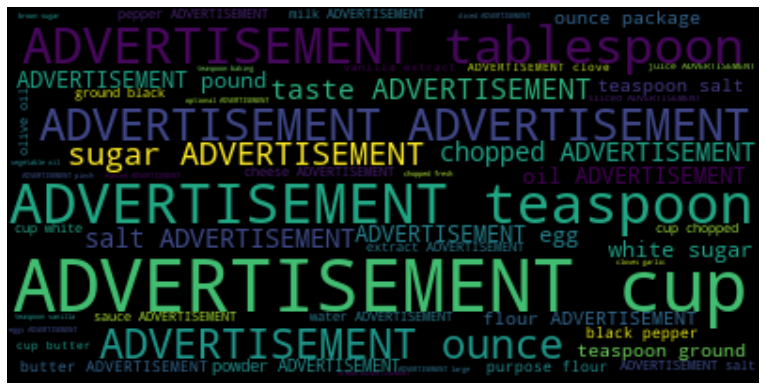

In [12]:
total_ingredients = nltk.flatten(df.ingredients.tolist())
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(total_ingredients))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

As one can see, olive oil is the most prominent ingredient. However, the ingredients include adjectives (chopped, fresh, unstalted, large etc.). This needs to be cleaned to obtain the real ingredients.

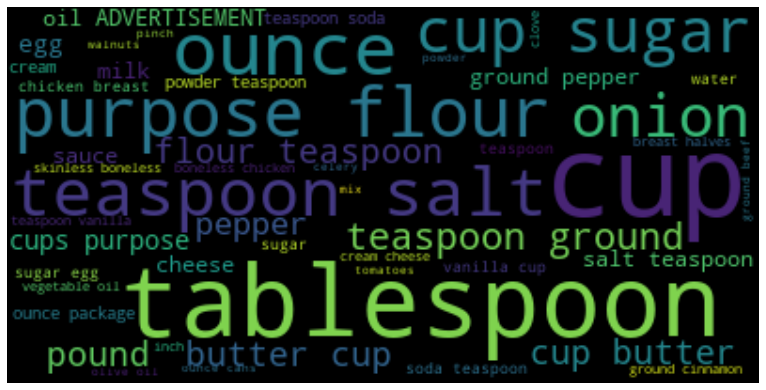

In [13]:
nlp = spacy.load("en_core_web_sm")
processed_ingredients = [nlp(text) for text in total_ingredients[:1000]]
nouns = [str(word) for ingredient in processed_ingredients for word in ingredient if word.pos_ == "NOUN"]
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(nouns))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

This looks better, but still cup is the most prominent word although it is a measure and not an ingredient. This probably has to be removed manually via a stopword list, tablespoon, teaspoon, pund, similarly. Interestingly words like vegetable are of course nouns but most likely appear in combination with stock for example where they are adjectives. This has to be taken care of. Why are lentils so prominent?

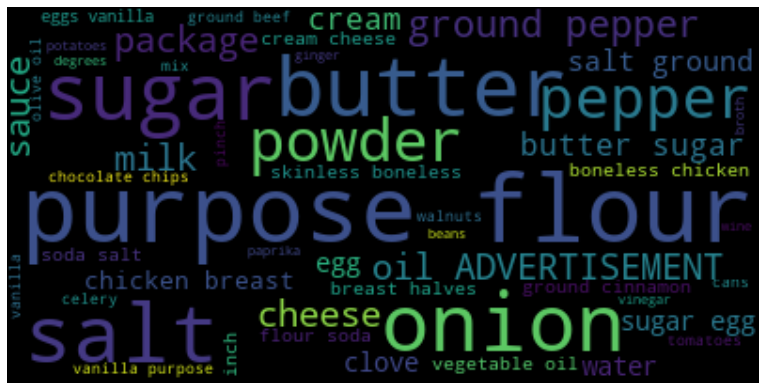

In [14]:
# without units (special stopwords)
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words |= {"cup", "cups", "tablespoon", "tablespoons", "teaspoon", "teaspoons", "pound", "pounds", "ounce", "ounces","slice","slices", "piece", "pieces", "ADVERTISEMENT"}
processed_ingredients = [nlp(text) for text in total_ingredients[:1000]]
nouns = [str(word) for ingredient in processed_ingredients for word in ingredient if (word.pos_ == "NOUN" and not word.is_stop)]
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(nouns))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")


## Directions

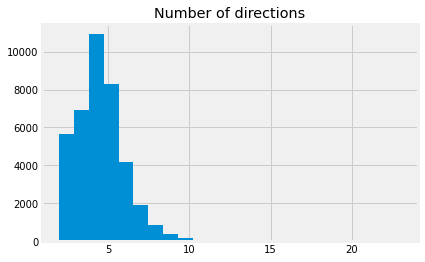

Median number of directions: 4.0
Std. deviation of number of directions: 1.70


In [25]:
def count_directions(directions):
    directions = directions.split('\n')
    if isinstance(directions, list):
        return len(directions)
    else:
        return 0

df['n_directions'] = df.instructions.apply(count_directions)

#plot distribution
plt.title("Number of directions")
plt.hist(df.n_directions.tolist(), bins=max(df.n_directions.tolist()))
plt.show()

print(f"Median number of directions: {df.n_directions.median()}")
print(f"Std. deviation of number of directions: {df.n_directions.std():.2f}")

Interestingly, ther are quite a lot of recipes with only a few directions (i.e. simple recipes). Only a samll number of recipes have more than 10 directions.

In [27]:
for i in range(0):
    recipe = df[df.n_directions == 0].iloc[i]
    print("{}: {}".format(recipe.title, len(recipe.ingredients)))

While some recipes with no instructions also have no ingredients, there are some which should have instructions. Interesstingly, most of the recipes are for drinks.

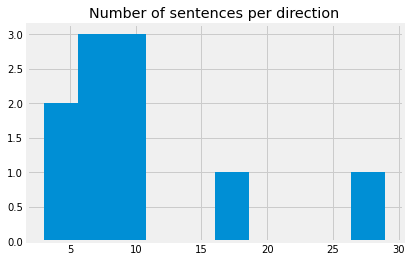

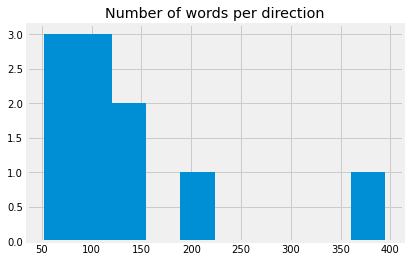

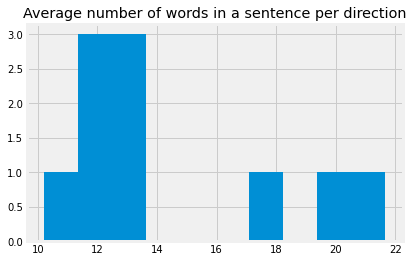

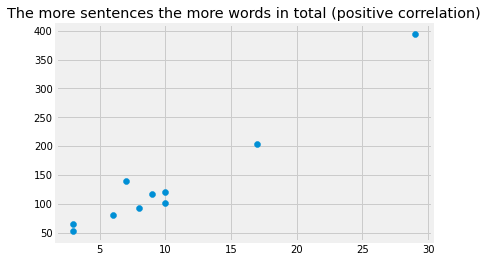

In [28]:
#number of words, sentences in directions 
processed_directions = [nlp(direction) for direction in nltk.flatten(df.instructions.tolist()[:10]) if isinstance(direction, str)]
sentences_per_direction = [len(list(processed_direction.sents)) for processed_direction in processed_directions]
plt.title("Number of sentences per direction")
plt.hist(sentences_per_direction)
plt.show()

words_per_direction = [len(processed_direction) for processed_direction in processed_directions]
plt.title("Number of words per direction")
plt.hist(words_per_direction)
plt.show()

plt.title("Average number of words in a sentence per direction")
plt.hist(np.array(words_per_direction) / np.array(sentences_per_direction))
plt.show()

plt.title("The more sentences the more words in total (positive correlation)")
plt.scatter(sentences_per_direction, words_per_direction)
plt.show()

This is varying quite a lot! So there is no clue if the directions are especially long or short. Of course the correlation between #words and #sentences is positive. Interestingly it is more a cloud than a line, so some variation.

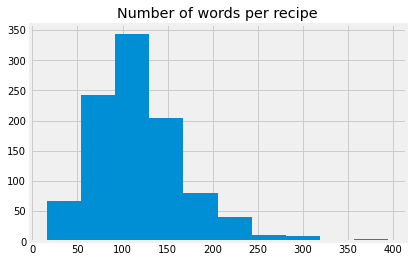

In [33]:
def count_words(directions):
    return len(nlp(directions)) 

df['word_count'] = df.instructions[:1000].apply(count_words)
plt.title("Number of words per recipe")
plt.hist(df.word_count.tolist())
plt.show()